### 필요한 모듈 import

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPool2D, ReLU, MaxPooling2D, Flatten, Dense, Convolution2DTranspose

import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import OrderedDict
from PIL import Image
from tensorflow.nn import relu
from tensorflow.math import reduce_max
from keras.utils.image_utils import img_to_array
import json

### Pretrained VGG16 모델
ImageNet-100K 로 pretrained 된 모델

In [2]:
vgg16_pretrained = tf.keras.applications.vgg16.VGG16(weights='imagenet',)
vgg16_pretrained.summary()

553467096/553467096 [==============================] - 21s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

### VGG16 모델
deconvolution 과정에서 필요한 max_indices 를 얻기 위해 기존 MaxPooling2D 레이어를 max_pool_with_argmax 로 변경

max_indices 는 self.pool_locs 에 저장

In [3]:
class Vgg16Conv(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.output_feats = {}
    self.pool_locs = OrderedDict()

    self.block1_conv1 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='block1_conv1')
    self.block1_conv2 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='block1_conv2')
    self.block1_pool = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block1_pool')
    

    self.block2_conv1 = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='block2_conv1')
    self.block2_conv2 = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='block2_conv2')
    self.block2_pool = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block2_pool')

    self.block3_conv1 = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='block3_conv1')
    self.block3_conv2 = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='block3_conv2')
    self.block3_conv3 = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='block3_conv3')
    self.block3_pool = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block3_pool')

    self.block4_conv1 = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block4_conv1')
    self.block4_conv2 = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block4_conv2')
    self.block4_conv3 = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block4_conv3')
    self.block4_pool = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block3_pool')

    self.block5_conv1 = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block5_conv1')
    self.block5_conv2 = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block5_conv2')
    self.block5_conv3 = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block5_conv3')
    self.block5_pool = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block3_pool')


    
    self.flatten = Flatten()
    self.fc1 = Dense(4096, activation='relu', name='fc1')
    self.fc2 = Dense(4096, activation='relu', name='fc2')
    self.fc3 = Dense(1000, name='predictions')

    # self.init_weights()
  
  def call(self, x):
    x = self.block1_conv1(x)
    self.output_feats[17] = x
    x = self.block1_conv2(x)
    self.output_feats[16] = x
    x, indices = tf.nn.max_pool_with_argmax(x ,ksize=2, strides=2, padding='VALID')
    self.pool_locs['block1_pool'] = indices
    self.output_feats[15] = x

    x = self.block2_conv1(x)
    self.output_feats[14] = x
    x = self.block2_conv2(x)
    self.output_feats[13] = x
    x, indices = tf.nn.max_pool_with_argmax(x ,ksize=2, strides=2, padding='VALID')
    self.pool_locs['block2_pool'] = indices
    self.output_feats[12] = x

    x = self.block3_conv1(x)
    self.output_feats[11] = x
    x = self.block3_conv2(x)
    self.output_feats[10] = x
    x = self.block3_conv3(x)
    self.output_feats[9] = x
    x, indices = tf.nn.max_pool_with_argmax(x ,ksize=2, strides=2, padding='VALID')
    self.pool_locs['block3_pool'] = indices
    self.output_feats[8] = x

    x = self.block4_conv1(x)
    self.output_feats[7] = x
    x = self.block4_conv2(x)
    self.output_feats[6] = x
    x = self.block4_conv3(x)
    self.output_feats[5] = x
    x, indices = tf.nn.max_pool_with_argmax(x ,ksize=2, strides=2, padding='VALID')
    self.pool_locs['block4_pool'] = indices
    self.output_feats[4] = x

    x = self.block5_conv1(x)
    self.output_feats[3] = x
    x = self.block5_conv2(x)
    self.output_feats[2] = x
    x = self.block5_conv3(x)
    self.output_feats[1] = x
    x, indices = tf.nn.max_pool_with_argmax(x ,ksize=2, strides=2, padding='VALID')
    self.pool_locs['block5_pool'] = indices
    self.output_feats[0] = x

    ## classification
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    logits = self.fc3(x)

    return logits

  def init_weights(self):
    for i, layer in enumerate(vgg16_pretrained.layers):
      if isinstance(layer, Dense):
        self.get_layer(layer.name).set_weights(layer.get_weights())

      if isinstance(layer, Conv2D):
        self.get_layer(layer.name).set_weights(layer.get_weights())

### Deconvolution 모델
Unpooling은 다른 곳에서 코드를 가져와서 사용

In [4]:
class Vgg16Deconv(tf.keras.Model):
  def __init__(self, pool_locs):
    super().__init__()

    self.depool_locs = pool_locs
    self.relu = relu
    self.deconv_layers = {
        0:0,
        1:Convolution2DTranspose(filters=512, kernel_size=3, padding='same', activation='relu', name='block5_deconv3', use_bias=False),
        2:Convolution2DTranspose(filters=512, kernel_size=3, padding='same', activation='relu', name='block5_deconv2', use_bias=False),
        3:Convolution2DTranspose(filters=512, kernel_size=3, padding='same', activation='relu', name='block5_deconv1', use_bias=False),
        4: 4,
        5:Convolution2DTranspose(filters=512, kernel_size=3, padding='same', activation='relu', name='block4_deconv3', use_bias=False),
        6:Convolution2DTranspose(filters=512, kernel_size=3, padding='same', activation='relu', name='block4_deconv2', use_bias=False),
        7:Convolution2DTranspose(filters=256, kernel_size=3, padding='same', activation='relu', name='block4_deconv1', use_bias=False),
        8:8,
        9:Convolution2DTranspose(filters=256, kernel_size=3, padding='same', activation='relu', name='block3_deconv3', use_bias=False),
        10:Convolution2DTranspose(filters=256, kernel_size=3, padding='same', activation='relu', name='block3_deconv2', use_bias=False),
        11:Convolution2DTranspose(filters=128, kernel_size=3, padding='same', activation='relu', name='block3_deconv1', use_bias=False),
        12:12,
        13:Convolution2DTranspose(filters=128, kernel_size=3, padding='same', activation='relu', name='block2_deconv2', use_bias=False),
        14:Convolution2DTranspose(filters=64, kernel_size=3, padding='same', activation='relu', name='block2_deconv1', use_bias=False),
        15:15,
        16:Convolution2DTranspose(filters=64, kernel_size=3, padding='same', activation='relu', name='block1_deconv2', use_bias=False),
        17:Convolution2DTranspose(filters=3, kernel_size=3, padding='same', activation='relu', name='block1_deconv1', use_bias=False),
      }
    self.conv2deconv = {1:17,2:16,4:14,5:13,7:11,8:10,9:9,11:7,12:6,13:5,15:3,16:2,17:1}

  def init_weights(self):
    for i, layer in enumerate(vgg16_pretrained.layers):
      if isinstance(layer, Conv2D):
        self.deconv_layers[self.conv2deconv[i]].set_weights([layer.get_weights()[0]])

  def call(self, x, layer, mark):

    for idx in range(layer, 18):
      if idx == 0:
        x = unpool_with_with_argmax(x, self.depool_locs['block5_pool'])
      elif idx == 4:
        x = unpool_with_with_argmax(x, self.depool_locs['block4_pool'])
      elif idx == 8:
        x = unpool_with_with_argmax(x, self.depool_locs['block3_pool'])
      elif idx == 12:
        x = unpool_with_with_argmax(x, self.depool_locs['block2_pool'])
      elif idx == 15:
        x = unpool_with_with_argmax(x, self.depool_locs['block1_pool'])
      else:
        x = self.deconv_layers[idx](x)

    return x

In [5]:
def unpool_with_with_argmax(pooled, ind, ksize=[1, 2, 2, 1]):
    """
      To unpool the tensor after  max_pool_with_argmax.
      Argumnets:
          pooled:    the max pooled output tensor
          ind:       argmax indices , the second output of max_pool_with_argmax
          ksize:     ksize should be the same as what you have used to pool
      Returns:
          unpooled:      the tensor after unpooling
      Some points to keep in mind ::
          1. In tensorflow the indices in argmax are flattened, so that a maximum value at position [b, y, x, c] becomes flattened index ((b * height + y) * width + x) * channels + c
          2. Due to point 1, use broadcasting to appropriately place the values at their right locations ! 

    """
    # Get the the shape of the tensor in th form of a list
    input_shape = pooled.get_shape().as_list()
    # Determine the output shape
    output_shape = (input_shape[0], input_shape[1] * ksize[1], input_shape[2] * ksize[2], input_shape[3])
    # Ceshape into one giant tensor for better workability
    pooled_ = tf.reshape(pooled, [input_shape[0] * input_shape[1] * input_shape[2] * input_shape[3]])
    # The indices in argmax are flattened, so that a maximum value at position [b, y, x, c] becomes flattened index ((b * height + y) * width + x) * channels + c
    # Create a single unit extended cuboid of length bath_size populating it with continous natural number from zero to batch_size
    batch_range = tf.reshape(tf.range(output_shape[0], dtype=ind.dtype), shape=[input_shape[0], 1, 1, 1])
    b = tf.ones_like(ind) * batch_range
    b_ = tf.reshape(b, [input_shape[0] * input_shape[1] * input_shape[2] * input_shape[3], 1])
    ind_ = tf.reshape(ind, [input_shape[0] * input_shape[1] * input_shape[2] * input_shape[3], 1])
    ind_ = tf.concat([b_, ind_],1)
    ref = tf.Variable(tf.zeros([output_shape[0], output_shape[1] * output_shape[2] * output_shape[3]]))
    # Update the sparse matrix with the pooled values , it is a batch wise operation
    unpooled_ = tf.tensor_scatter_nd_update(ref, ind_, pooled_)
    # Reshape the vector to get the final result 
    unpooled = tf.reshape(unpooled_, [output_shape[0], output_shape[1], output_shape[2], output_shape[3]])
    return unpooled

### 이미지 불러오기
opencv-python 으로 이미지를 읽어와 전처리 후 모델의 입력에 맞게 텐서로 변환

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


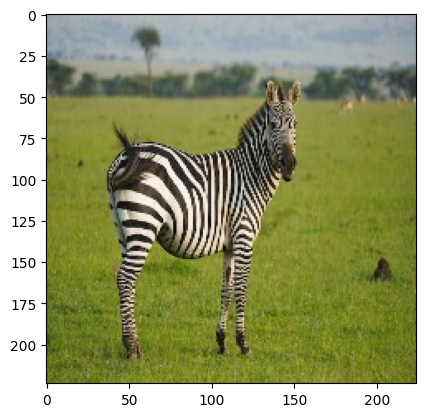

In [16]:
from google.colab import drive
drive.mount('/content/drive')

image = cv2.imread('drive/MyDrive/Test/LIG/zebra.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224,224))
plt.imshow(image)
plt.show()

In [17]:
image_tensor = tf.cast(image, tf.float32)
image_tensor = tf.keras.applications.vgg16.preprocess_input(image_tensor)
image_tensor = np.expand_dims(image_tensor,0)

### Vgg16 모델 weight_initialization
Vgg16 모델의 weight 를 pretrained 된 vgg16의 weight 로 초기화

In [18]:
vgg16_conv = Vgg16Conv()
vgg16_conv.build(input_shape=[None,224,224,3])
vgg16_conv.init_weights()

### Feed Forward vgg16_conv
vgg16_conv 모델에 위에서 불러온 예제 이미지(image)를 입력으로 하여 각 레이어별 feature_map, pool_location 추출

In [19]:
import json
with open('drive/MyDrive/Test/LIG/imagenet_class_index.json') as file:
  labels = json.load(file)

In [20]:
vgg16_conv.trainable = False
logits = vgg16_conv(image_tensor)
print('Predicted:', labels[str(np.argmax(logits[0]))][1])

Predicted: zebra


### Visualization 함수

In [13]:
def vis_layer(layer, vgg16_conv, vgg16_deconv):
    """
    visualing the layer deconv result
    """
    for i in list(vgg16_conv.output_feats.keys()):
      mean = np.mean(vgg16_conv.output_feats[i])
      std = np.std(vgg16_conv.output_feats[i])
      vgg16_conv.output_feats[i] = (vgg16_conv.output_feats[i] - mean) / std

    num_feat = vgg16_conv.output_feats[layer].shape[-1] # channel
    
    # set other feature map activations to zero
    new_feat_map = tf.identity(vgg16_conv.output_feats[layer]).numpy() # [NHWC] tf.identity?

    # choose the max activations map
    act_lst = []
    for i in range(0, num_feat):
        choose_map = new_feat_map[0, :, :, i]
        activation = reduce_max(choose_map) # max 인 indices 저장?
        act_lst.append(activation.numpy())

    act_lst = np.array(act_lst)
    mark = np.argmax(act_lst)
    # print('mark', mark)
    choose_map = new_feat_map[0, :, :, mark]
    max_activation = reduce_max(choose_map) 
    
    # make zeros for other feature maps
    if mark == 0:
      new_feat_map[:, 1:, :, :] = 0
    else:
      new_feat_map[:, :, :, :mark] = 0
      if mark != vgg16_conv.output_feats[layer].shape[-1] - 1:
          new_feat_map[:, :, :, mark + 1:] = 0
  
    choose_map = tf.where(choose_map==max_activation, choose_map, tf.zeros(choose_map.shape))

    # make zeros for ther activations
    new_feat_map[0, :, :, mark] = choose_map

    deconv_output = vgg16_deconv(new_feat_map, layer, mark)

    new_img = deconv_output.numpy()[0]  # (H, W, C)
    

    # print(new_img.min(), new_img.max(), new_img.mean())

    # normalize
    new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min()) * 255
    new_img = new_img.astype(np.uint8)

    return new_img, int(max_activation)


### Vgg16_deconv 모델 weight_initialization
Deconvolution 모델의 weight 를 pretrained 된 vgg16 의 weight 로 초기화

In [22]:
vgg16_deconv = Vgg16Deconv(vgg16_conv.pool_locs)
_ = vis_layer(0, vgg16_conv, vgg16_deconv)
vgg16_deconv.init_weights()
vgg16_deconv.trainable = False

### Deconvolution 결과
깊은 층에서는 얼굴 같이 high-level 영역에 대해 큰 activation 을 보임

얕은 층에서 눈, 코 같은 영역이 가장 큰 activation 을 보임

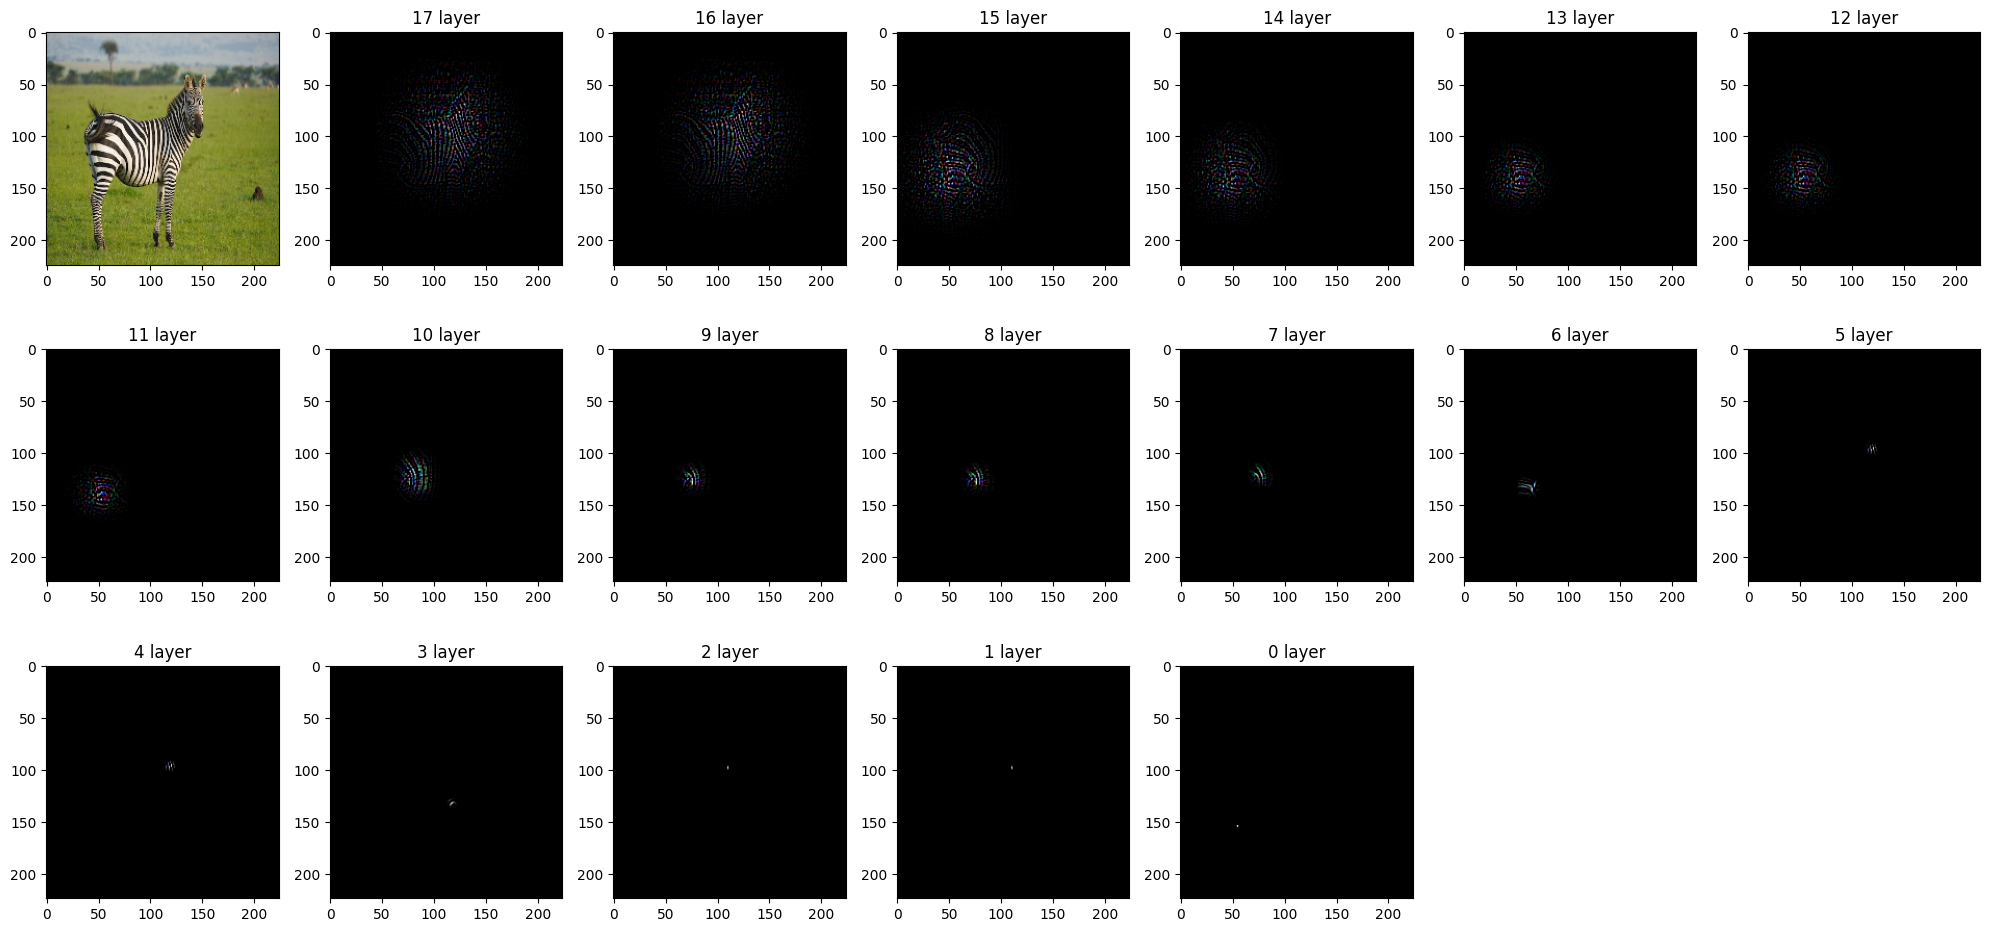

In [23]:
ref_image = Image.open('drive/MyDrive/Test/LIG/zebra.jpg')
ref_image = ref_image.resize((224,224))

plt.figure(figsize=(20, 10))

plt.subplot(3,7,1)
plt.imshow(ref_image)   

for idx, layer in enumerate(range(18)):
    plt.subplot(3,7,idx+2)
    plt.tight_layout()
    img, activation = vis_layer(layer, vgg16_conv, vgg16_deconv)
    # plt.title(f'{layer} layer, the max activations is {activation}')
    plt.title(f'{17-idx} layer')
    plt.imshow(img)

plt.show()